In [10]:
import os
import shutil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from invert import invert_ebb
from simulate import run_current_density_simulation
from laminar import model_comparison
from matplotlib import colors

In [11]:
sim_vertex=420
freq=20
dipole_moment=10
sim_patch_size=5
SNR=-5
n_layers=11
layers = np.linspace(1, 0, n_layers)

data_dir='./test_data'
out_dir='./test_output'
tmp_dir='/scratch/bonaiuto/simulated_data/model_comp_cverr'
subj_id='sub-104'
ses_id='ses-01'
# Subject fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# T1
mri_fname = os.path.join(data_dir,'spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')

mesh_fname = os.path.join(out_dir, subj_id, 'multilayer.11.ds.link_vector.gii')

## Create intermediate surfaces if needed
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join(out_dir, subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'white.ds.link_vector.gii'))

# Data file to base simulations on
data_file=os.path.join(data_dir, 'processed', subj_id, ses_id, 'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')

patch_size=5
n_temp_modes = 4
# Number of cross validation folds
n_folds=10
# Percentage of test channels in cross validation
ideal_pc_test=10 # may not use this number as we need integer number of channels

mesh=nib.load(mesh_fname)
verts_per_surf=mesh.darrays[0].data.shape[0]/n_layers


In [3]:
# Invert the subject's data. This step only has to be done once
[base_fname,_,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, data_file, n_layers, 
                            patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


Text(0, 0.5, 'Amplitude (nAm)')

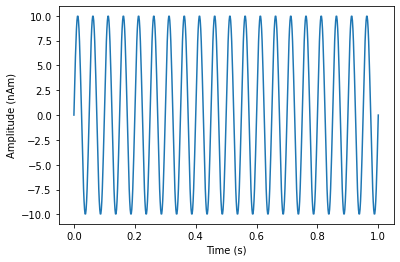

In [12]:
time=np.linspace(0,1,601)
sim_signal=np.sin(time*freq*2*np.pi).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [5]:
# Simulate on pial surface
pial_vertex=sim_vertex
prefix=f'sim_{sim_vertex}_pial.'
pial_sim_fname=run_current_density_simulation(base_fname, prefix, pial_vertex, sim_signal, dipole_moment, 
                                              sim_patch_size, SNR)    
[_,cvErr]=model_comparison(tmp_dir, nas, lpa, rpa, mri_fname, [layer_fnames[0], layer_fnames[-1]], 
                           pial_sim_fname, patch_size=sim_patch_size, n_temp_modes=n_temp_modes, n_folds=n_folds,
                           ideal_pc_test=ideal_pc_test)
np.mean(np.mean(cvErr[1],axis=-1),axis=-1)-np.mean(np.mean(cvErr[0],axis=-1),axis=-1)

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


0.22963202914330338

In [6]:
# Simulate on white matter surface
white_vertex=(n_layers-1)*verts_per_surf+sim_vertex
prefix=f'sim_{sim_vertex}_white.'
white_sim_fname=run_current_density_simulation(base_fname, prefix, white_vertex, sim_signal, dipole_moment, 
                                               sim_patch_size, SNR) 
[_,cvErr]=model_comparison(tmp_dir, nas, lpa, rpa, mri_fname, [layer_fnames[0], layer_fnames[-1]], 
                           white_sim_fname, patch_size=sim_patch_size, n_temp_modes=n_temp_modes, n_folds=n_folds,
                           ideal_pc_test=ideal_pc_test)
np.mean(np.mean(cvErr[1],axis=-1),axis=-1)-np.mean(np.mean(cvErr[0],axis=-1),axis=-1)

Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


-0.23104887287343345

In [7]:
all_layerCvErr=[]
for l in range(len(layers)):
    print(f'Simulating in layer {l}')
    l_vertex=l*verts_per_surf+sim_vertex
    prefix=f'sim_{sim_vertex}_l.'
    l_sim_fname=run_current_density_simulation(base_fname, prefix, l_vertex, sim_signal, dipole_moment, 
                                               sim_patch_size, SNR) 
    [_,layerCvErr]=model_comparison(tmp_dir, nas, lpa, rpa, mri_fname, layer_fnames, l_sim_fname, 
                                    patch_size=sim_patch_size, n_temp_modes=n_temp_modes, n_folds=n_folds,
                                    ideal_pc_test=ideal_pc_test)
    all_layerCvErr.append(layerCvErr)
all_layerCvErr=np.array(all_layerCvErr)
all_layerCvErr=np.mean(np.mean(all_layerCvErr, axis=-1), axis=-1)

Simulating in layer 0
Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ./test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ./test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ./test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ./test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ./test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ./test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ./test_output/sub-104/0.200.ds.link_vector.gii
FWHM of 5.00 is approx 3.48 times vertex spacing
Smoothing ./test_output/s

Smoothing ./test_output/sub-104/white.ds.link_vector.gii
FWHM of 5.00 is approx 3.58 times vertex spacing
Simulating in layer 7
Smoothing ./test_output/sub-104/pial.ds.link_vector.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ./test_output/sub-104/0.900.ds.link_vector.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ./test_output/sub-104/0.800.ds.link_vector.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ./test_output/sub-104/0.700.ds.link_vector.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ./test_output/sub-104/0.600.ds.link_vector.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ./test_output/sub-104/0.500.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ./test_output/sub-104/0.400.ds.link_vector.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ./test_output/sub-104/0.300.ds.link_vector.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ./test_output/s

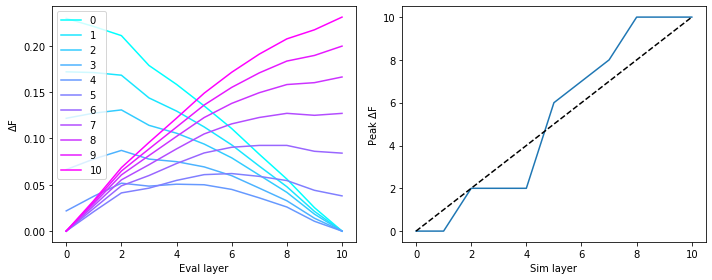

In [8]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    layerCvErr=all_layerCvErr[l,:]
    plt.plot(np.max(layerCvErr)-layerCvErr, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerCvErr=all_layerCvErr[l,:]
    layerCvErr=np.max(layerCvErr)-layerCvErr
    pk=np.argmax(layerCvErr)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [9]:
# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)